In [1]:
!pip3 install polygon-api-client pandas requests matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import requests
from polygon import RESTClient
import matplotlib.pyplot as plt

/Users/brunoinzunza/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
#Polygon API
api_key = "api-key"
client = RESTClient(api_key)

In [4]:
def data(ticker='C:EURUSD', timespan='minute', from_date='2023-01-01', to_date='2024-01-01', limit=50000):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{timespan}/{from_date}/{to_date}?adjusted=true&sort=asc&limit={limit}&apiKey={api_key}"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")
    
    data = response.json()
    df = pd.DataFrame(data['results'])
    df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
    df.rename(columns={'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'}, inplace=True)
    df.drop(columns=['vw', 'n', 't'], inplace=True)
    return df

data = data()
data

,Volume,Open,Close,High,Low,timestamp
0,1,1.06849,1.06849,1.06849,1.06849,2023-01-01 18:21:00
1,1,1.06839,1.06839,1.06839,1.06839,2023-01-01 18:46:00
2,1,1.06799,1.06799,1.06799,1.06799,2023-01-01 19:11:00
3,1,1.06789,1.06789,1.06789,1.06789,2023-01-01 19:36:00
4,1,1.06789,1.06789,1.06789,1.06789,2023-01-01 20:27:00
...,...,...,...,...,...,...
49995,20,1.06940,1.06950,1.06961,1.06940,2023-02-17 21:08:00
49996,39,1.06940,1.06954,1.06960,1.06940,2023-02-17 21:09:00
49997,33,1.06956,1.06940,1.06960,1.06940,2023-02-17 21:10:00
49998,38,1.06953,1.06945,1.06960,1.06930,2023-02-17 21:11:00


In [11]:
def signals(df, short_window=1, medium_window=5, long_window=25):
    df['short_mavg'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['medium_mavg'] = df['Close'].rolling(window=medium_window, min_periods=1).mean()
    df['long_mavg'] = df['Close'].rolling(window=long_window, min_periods=1).mean()
    
    df['Sell Signal'] = (df['medium_mavg'][short_window:] > df['long_mavg'][short_window:]) & (df['short_mavg'][short_window:] > df['medium_mavg'][short_window:])
    df['Buy Signal'] = (df['medium_mavg'][short_window:] < df['long_mavg'][short_window:]) & (df['short_mavg'][short_window:] < df['medium_mavg'][short_window:])
    
    return df

data_w_signals = signals(data)
data_w_signals

,Volume,Open,Close,High,Low,timestamp,short_mavg,medium_mavg,long_mavg,Buy Signal,Sell Signal
0,1,1.06849,1.06849,1.06849,1.06849,2023-01-01 18:21:00,1.06849,1.068490,1.068490,NaN,NaN
1,1,1.06839,1.06839,1.06839,1.06839,2023-01-01 18:46:00,1.06839,1.068440,1.068440,False,False
2,1,1.06799,1.06799,1.06799,1.06799,2023-01-01 19:11:00,1.06799,1.068290,1.068290,False,False
3,1,1.06789,1.06789,1.06789,1.06789,2023-01-01 19:36:00,1.06789,1.068190,1.068190,False,False
4,1,1.06789,1.06789,1.06789,1.06789,2023-01-01 20:27:00,1.06789,1.068130,1.068130,False,False
...,...,...,...,...,...,...,...,...,...,...,...
49995,20,1.06940,1.06950,1.06961,1.06940,2023-02-17 21:08:00,1.06950,1.069566,1.069536,False,False
49996,39,1.06940,1.06954,1.06960,1.06940,2023-02-17 21:09:00,1.06954,1.069550,1.069538,False,False
49997,33,1.06956,1.06940,1.06960,1.06940,2023-02-17 21:10:00,1.06940,1.069518,1.069531,True,False
49998,38,1.06953,1.06945,1.06960,1.06930,2023-02-17 21:11:00,1.06945,1.069498,1.069533,True,False


In [12]:
def backtest(df, initial_balance=10000):
    position = 0
    entry_price = 0
    realized_gains = 0
    trades = []

    for i in range(1, len(df)):
        trade_data = {}

        if df['Buy Signal'][i] and position != 1:
            trade_data['Time'] = df['timestamp'][i]
            trade_data['Price'] = df['Close'][i]
            trade_data['Position'] = 1
            if(position == -1):
                profit = entry_price - df['Close'][i]
                trade_data['Profit'] = profit
                realized_gains += profit
                trade_data['Realized'] = realized_gains
                if(profit > 0):
                    trade_data['Result'] = "Win"
                else:
                    trade_data['Result'] = "Loss"
            else:
                trade_data['Realized'] = 0
            trade_data['Balance'] = initial_balance + realized_gains
            trades.append(trade_data)
            position = 1
            entry_price = df['Close'][i]

        elif df['Sell Signal'][i] and position != -1:
            trade_data['Time'] = df['timestamp'][i]
            trade_data['Price'] = df['Close'][i]
            trade_data['Position'] = -1
            if(position == 1):
                profit = df['Close'][i] - entry_price
                trade_data['Profit'] = profit
                realized_gains += profit
                trade_data['Realized'] = realized_gains
                if(profit > 0):
                    trade_data['Result'] = "Win"
                else:
                    trade_data['Result'] = "Loss"
            else:
                trade_data['Realized'] = 0
            trade_data['Balance'] = initial_balance + realized_gains
            trades.append(trade_data)
            position = -1
            entry_price = df['Close'][i]

    trade_df = pd.DataFrame(trades)

    return trade_df

backtest_results = backtest(data_w_signals)
backtest_results

,Time,Price,Position,Realized,Balance,Profit,Result
0,2023-01-01 20:52:00,1.06789,1,0.00000,10000.00000,NaN,NaN
1,2023-01-01 23:22:00,1.06960,-1,0.00171,10000.00171,0.00171,Win
2,2023-01-02 00:22:00,1.06955,1,0.00176,10000.00176,0.00005,Win
3,2023-01-02 00:40:00,1.06970,-1,0.00191,10000.00191,0.00015,Win
4,2023-01-02 01:16:00,1.07060,1,0.00101,10000.00101,-0.00090,Loss
...,...,...,...,...,...,...,...
2624,2023-02-17 20:19:00,1.06930,1,0.21741,10000.21741,0.00016,Win
2625,2023-02-17 20:25:00,1.06975,-1,0.21786,10000.21786,0.00045,Win
2626,2023-02-17 20:30:00,1.06941,1,0.21820,10000.21820,0.00034,Win
2627,2023-02-17 21:01:00,1.06973,-1,0.21852,10000.21852,0.00032,Win


In [13]:
def analysis(trade_df, initial_balance=10000):
    num_trades = len(trade_df)
    winrate = ((trade_df['Result'] == "Win").sum() / num_trades) * 100
    final_balance = trade_df['Balance'].tail(1).values[0]
    net_returns = final_balance - initial_balance
    percent_return = (final_balance / initial_balance)
    avg_profit_per_trade = net_returns / num_trades
    largest_win = trade_df['Profit'].max()
    largest_loss = trade_df['Profit'].min()
    print(f'Winrate: {winrate}%')
    print(f'Final Balance: {final_balance}')
    print(f'Net Returns: {net_returns}')
    print(f'Percentage Returns: {percent_return}%')
    print(f'Total Trades: {num_trades}')
    print(f'Average Profit per Trade: {avg_profit_per_trade}')
    print(f'Largest Win: {largest_win}')
    print(f'Largest Loss: {largest_loss}')

analysis(backtest_results)

Winrate: 72.91745910992773%
Final Balance: 10000.21885
Net Returns: 0.21884999999929278
Percentage Returns: 1.000021885%
Total Trades: 2629
Average Profit per Trade: 8.324457968782532e-05
Largest Win: 0.005579999999999918
Largest Loss: -0.009340000000000126


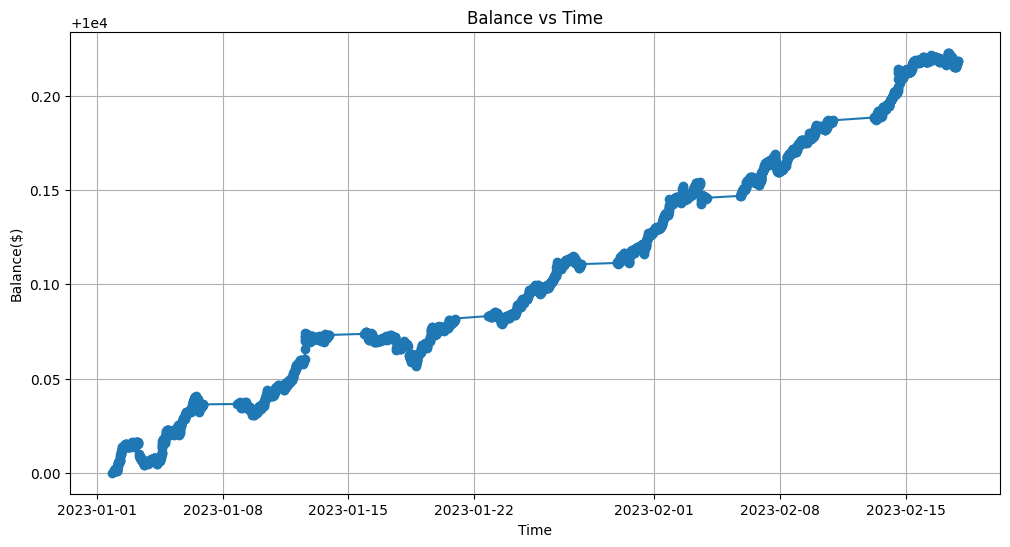

In [14]:
def plots(trade_df):
    plt.figure(figsize=(12, 6))
    plt.plot(trade_df['Time'], trade_df['Balance'], marker='o', linestyle='-')
    plt.title("Balance vs Time")
    plt.xlabel("Time")
    plt.ylabel("Balance($)")
    plt.grid()
    plt.show()

plots(backtest_results)